# Bayesian Logistic Regression with PyMC3
* This is a reproduction with a few slight alterations of [Bayesian Log Reg](http://jbencook.github.io/portfolio/bayesian_logistic_regression.html) by J. Benjamin Cook
* How likely am I to make more than $50,000 US Dollars?

In [62]:

%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as T

The [Adult Data Set](http://archive.ics.uci.edu/ml/datasets/Adult) is commonly used to benchmark machine learning algorithms. The goal is to use demographic features, or variables, to predict whether an individual makes more than \\$50,000 per year. The data set is almost 20 years old, and therefore, not perfect for determining the probability that I will make more than \$50K, but it is a nice, simple dataset that can be used to showcase a few benefits of using Bayesian logistic regression over its frequentist counterpart.


The motivation for myself to reproduce this piece of work was to learn how to use Odd Ratio in Bayesian Regression.

In [2]:
data = pd.read_csv("data/salary_data.csv", header=None, skiprows=1, names=['age', 'workclass', 'fnlwgt', 
                'education-categorical', 'educ', 
                'marital-status', 'occupation',
                'relationship', 'race', 'sex', 
                'captial-gain', 'capital-loss', 
                'hours', 'native-country', 
                'income'])

In [3]:
data

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
data = data[~pd.isnull(data['income'])]


In [5]:
data[data['native-country']==" United-States"]

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K
10,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,0.0,80.0,United-States,>50K
12,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [6]:
income = 1 * (data['income'] == " >50K")
age2 = np.square(data['age'])

In [7]:
data = data[['age', 'educ', 'hours']]
data['age2'] = age2
data['income'] = income

In [8]:
income.value_counts()

0    8190
1    2552
Name: income, dtype: int64

# The sampling
We will use a simple model, which assumes that the probability of making more than $50K 
is a function of age, years of education and hours worked per week. We will use PyMC3 
do inference. 

In Bayesian statistics, we treat everything as a random variable and we want to know the posterior probability distribution of the parameters
(in this case the regression coefficients)
The posterior is equal to the likelihood $$p(\theta | D) = \frac{p(D|\theta)p(\theta)}{p(D)}$$

Because the denominator is a notoriously difficult integral, $p(D) = \int p(D | \theta) p(\theta) d \theta $ we would prefer to skip computing it. Fortunately, if we draw examples from the parameter space, with probability proportional to the height of the posterior at any given point, we end up with an empirical distribution that converges to the posterior as the number of samples approaches infinity.  

What this means in practice is that we only need to worry about the numerator. 

## The model 
Getting back to logistic regression, we need to specify a prior and a likelihood in order to draw samples from the posterior. We could use sociological knowledge about the effects of age and education on income, but instead, let's use the default prior specification for GLM coefficients that PyMC3 gives us, which is $p(θ)=N(0,10^{12}I)$. This is a very vague prior that will let the data speak for themselves.

The likelihood is the product of n Bernoulli trials, $\prod^{n}_{i=1} p_{i}^{y} (1 - p_{i})^{1-y_{i}}$,
where $p_{i} = 
\frac{1}{1-e^{-z_{i}}},$, 

$z_{i} = \beta_{0} + \beta_{1}(age)_{i} + \beta_2(age)^{2}_{i} + \beta_{3}(educ)_{i} + \beta_{4}(hours)_{i}$ 
and $y_{i} = 1$ if income is greater than 50K and $y_{i} = 0$ otherwise. 

With the math out of the way we can get back to the data. Here I use PyMC3 to draw samples from the posterior. The sampling algorithm used is NUTS, which is a form of Hamiltonian Monte Carlo, in which parameteres are tuned automatically. Notice, that we get to borrow the syntax of specifying GLM's from R, very convenient! The last line in this cell tosses out the first 1000 samples, which are taken before the Markov Chain has converged and therefore do not come from our target distribution.

In [49]:
with pm.Model() as model:
    pm.GLM.from_formula('income ~ age + age2 + educ + hours', data)
    trace = pm.sample(2000, init='advi', progressbar=True)
    posterior_predictive = pm.sample_posterior_predictive(trace)
trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 11,383:  30%|██▉       | 59361/200000 [01:04<02:31, 925.94it/s]    
Convergence achieved at 59400
Interrupted at 59,399 [29%]: Average Loss = 6.8425e+08
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, hours, educ, age2, age, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:27<00:00, 58.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 8000/8000 [00:18<00:00, 442.58it/s]


# Some results 
One of the major benefits that makes Bayesian data analysis worth the extra computational effort in many circumstances is that we can be explicit about our uncertainty. Maximum likelihood returns a number, but how certain can we be that we found the right number? Instead, Bayesian inference returns a distribution over parameter values.

I’ll use seaborn to look at the distribution of some of these factors.

In [23]:
trace.varnames

['Intercept', 'age', 'age2', 'educ', 'hours', 'sd_log__', 'sd']

In [51]:
trace['age']

array([0.02465478, 0.02409997, 0.0263619 , ..., 0.02477978, 0.02727044,
       0.02479005])

<Figure size 648x504 with 0 Axes>

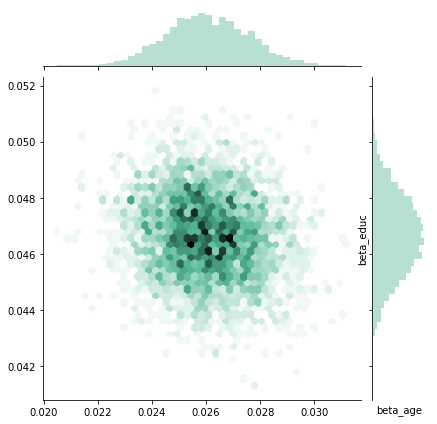

In [52]:
plt.figure(figsize=(9,7))
seaborn.jointplot(trace['age'], trace['educ'], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ")
plt.show()

So how do age and education affect the probability of making more than `$50K?`
To answer this question, we can show how the probability of making more than `$50K` changes with age for a few different education levels. 

Here, we assume that the number of hours worked per week is fixed at 50. PyMC3 gives us a convenient way to plot the posterior predictive distribution. We need to give the function a linear model and a set of points to evaluate. We will pass in three different linear models: one with `educ == 12` (finished high school), one with `educ == 16` (finished undergrad) and one with `educ == 19` (three years of grad school).

In [53]:
# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*12 + 
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*16 + 
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*19 + 
                                          samples['hours']*50)))


Each curve shows how the probability of earning more than $ 50K$ changes with age. The red curve represents 19 years of education, the green curve represents 16 years of education and the blue curve represents 12 years of education. For all three education levels, the probability of making more than $50K increases with age until approximately age 60, when the probability begins to drop off. Notice that each curve is a little blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. Because the curves are somewhat translucent, we can interpret dark, narrow portions of a curve as places where we have low uncertainty and light, spread out portions of the curve as places where we have somewhat higher uncertainty about our coefficient values.

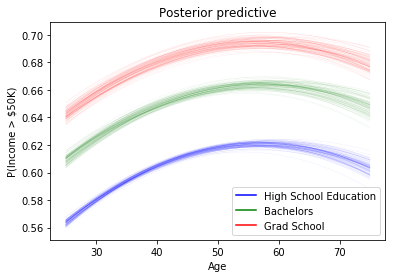

In [56]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=.15)
import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='High School Education')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Bachelors')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Grad School')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()


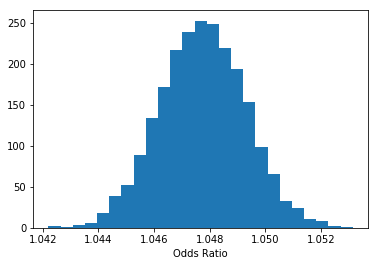

In [57]:
b = trace['educ']
plt.hist(np.exp(b), bins=25, normed=True)
plt.xlabel("Odds Ratio")
plt.show()


Finally, we can find a confidence interval for this quantity. This may be the best part about Bayesian statistics: we get to interpret confidence intervals the way we've always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval!

In [ ]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P(%.3f < O.R. < %.3f) = 0.95"%(np.exp(3*lb),np.exp(3*ub)))

In [65]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Normal())

            traces[nm] = pm.sample(2000, chains=1, init=None, tune=1000)

    return models, traces

def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

# Model selection
One question that was immediately asked was what effect does age have on the model, and why should it be age2 versus age? We’ll run the model with a few changes to see what effect higher order terms have on this model in terms of WAIC.

In [66]:
models_lin, traces_lin = run_models(data, 4)



Running: k1


Sequential sampling (1 chains in 1 job)
NUTS: [sd, age, hours, educ, Intercept]
100%|██████████| 3000/3000 [00:25<00:00, 117.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks



Running: k2


Sequential sampling (1 chains in 1 job)
NUTS: [sd, np.power(age, 2), age, hours, educ, Intercept]
100%|██████████| 3000/3000 [01:16<00:00, 39.24it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks



Running: k3


Sequential sampling (1 chains in 1 job)
NUTS: [sd, np.power(age, 3), np.power(age, 2), age, hours, educ, Intercept]
100%|██████████| 3000/3000 [04:30<00:00, 11.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks



Running: k4


Sequential sampling (1 chains in 1 job)
NUTS: [sd, np.power(age, 4), np.power(age, 3), np.power(age, 2), age, hours, educ, Intercept]
100%|██████████| 3000/3000 [14:53<00:00,  3.36it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


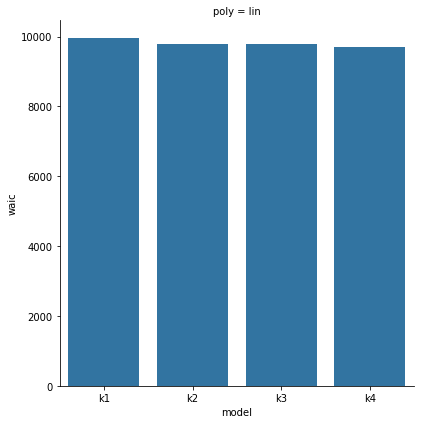

In [67]:
dfwaic = pd.DataFrame(index=['k1','k2','k3','k4'], columns=['lin'])
dfwaic.index.name = 'model'

for nm in dfwaic.index:
    dfwaic.loc[nm, 'lin'] = pm.waic(traces_lin[nm],models_lin[nm])[0]


dfwaic = pd.melt(dfwaic.reset_index(), id_vars=['model'], var_name='poly', value_name='waic')

g = seaborn.factorplot(x='model', y='waic', col='poly', hue='poly', data=dfwaic, kind='bar', size=6)

Since k2 is the lowest here - it confirms our choice to use k2. 